# Deep Belief Modeling
Project for SI course

## Imports

In [1]:
import pickle
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from collections import Counter
from minisom import MiniSom

from preprocessing.vectors import prepare_dictionary,generate_vectors, find_close_words
from som.plot import plot_vectors
from preprocessing.article import random_percent
from model.features import f_importances_graph
from preprocessing.article import word_preprocess

## Loading data

In [2]:
articles = pd.read_csv("resources/data.csv", sep="\t")

## Input data visualisation

<AxesSubplot:>

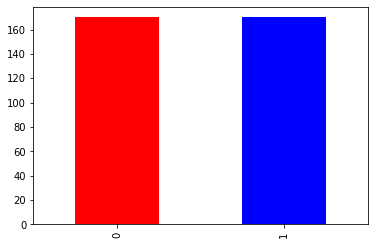

In [3]:
x = articles["label"].value_counts()
x.plot(kind="bar", color=["r", "b"])

## Text pre-processing for classification

In [4]:
print(articles["data"].head(10))
print(articles["data"].head(10).apply(word_preprocess))

0    It's been quite a week. I've been in the media...
1    This week has been eye-opening. Even for me --...
2    Yes, it's true. I beat COVID-19 in 48 hours wi...
3    The COVID-19 vaccines appear to be causing a g...
4    Back in the 1980s, I was a Columbia University...
5    So you got the vaccine because they told you t...
6    I Am A Living Proof That COVID-19 Is Fake This...
7    I have a PhD in virology and immunology. I’m a...
8    How do you convince the world’s population to ...
9    Take 15 minutes and listen to this interview w...
Name: data, dtype: object
0    [quite, week, medium, business, decade, never,...
1    [week, eye, opening, even, guy, warned, year, ...
2    [yes, true, beat, covid, hour, ivermectin, get...
3    [covid, vaccine, appear, causing, global, heal...
4    [back, columbia, university, student, learning...
5    [got, vaccine, told, get, forced, get, joe, bi...
6    [living, proof, covid, fake, unfiltered, take,...
7    [phd, virology, immunology, clinic

## Feature selection

### Pickle import

In [5]:
with open("model_storage/vectorizer.pkl","rb") as file:
    tfidf_vectorizer = pickle.load(file)

with open("model_storage/bow.pkl","rb") as file:
    tfidf_wm = pickle.load(file)

with open("model_storage/classifier.pkl","rb") as file:
    sgdc_classifier = pickle.load(file)


with open("model_storage/words_pa.pkl","rb") as file:
    words_pa = pickle.load(file)

tfidf_tokens = tfidf_vectorizer.get_feature_names_out()

print(tfidf_tokens)

df_tfidf_vect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

print("Tf-idf vectorizer")
print(df_tfidf_vect)


['aabduzrw' 'aaby' 'aadhaar' ... 'zoster' 'zuckerberg' 'zurich']
Tf-idf vectorizer
     aabduzrw  aaby  aadhaar  aaho  aamc  aamcnews  aap  aaphowever  aarogya  \
0         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
1         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
2         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
3         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
4         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
..        ...   ...      ...   ...   ...       ...  ...         ...      ...   
335       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
336       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
337       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
338       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
339       0.0   0.0      0.0   0.0   

### Plots

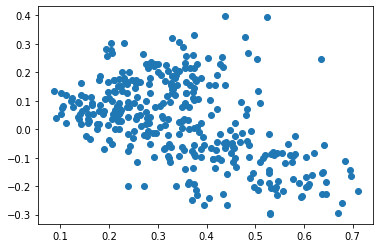

In [6]:
clftr = TruncatedSVD(2)
Xpca = clftr.fit_transform(tfidf_wm)
plt.scatter([x[0] for x in Xpca],[x[1] for x in Xpca])
plt.show()

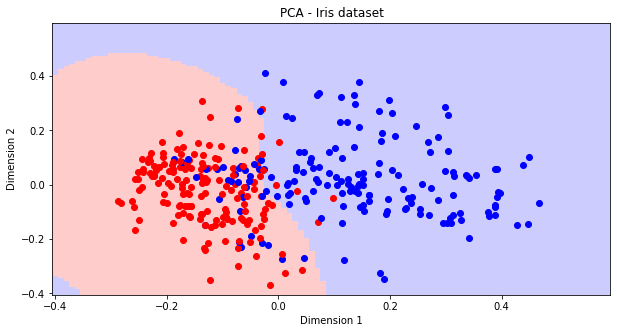

In [7]:
h = .01
x_min, x_max = -0.4,0.6
y_min, y_max = -0.4,0.6
# loading dataset
X, y = tfidf_wm.toarray(), articles["label"]
# selecting first 2 components of PCA
X_selected = PCA(2).fit_transform(X)
# training classifier and evaluating on the whole plane
clfsvc = SVC()
clfsvc.fit(X_selected,y)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clfsvc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Iris dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
for xy,c in zip(X_selected,articles["label"]):
    plt.scatter(xy[0],xy[1],c= 'red' if c == 0 else 'blue')
plt.show()

### Key words

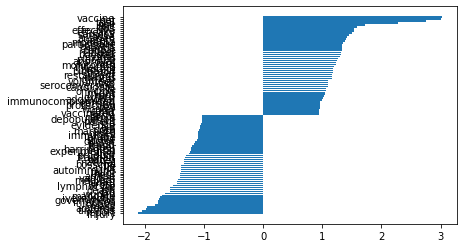

In [8]:
key_anti_words, key_pro_words = f_importances_graph(sgdc_classifier.coef_,tfidf_tokens, limit=50)


### Article vectors

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5189765530566142


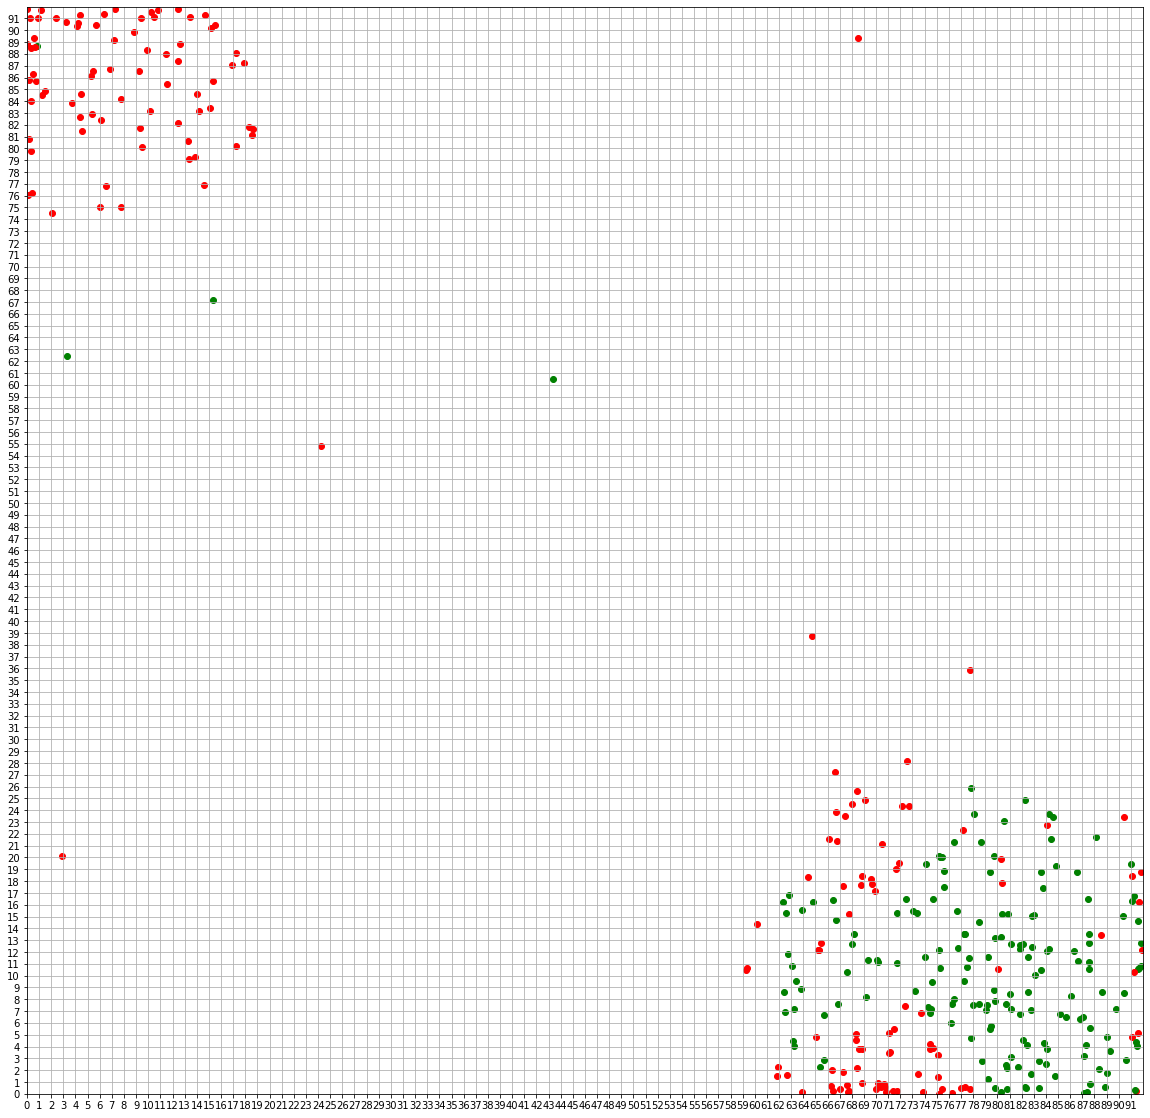

In [9]:
key_words = [s for _,s in key_pro_words+key_anti_words]
article_vectors = []


for a in words_pa:
    zliczone = Counter([word for word in a if word in key_words])
    article_vectors.append([zliczone[s] for s in key_words])

article_vectors = TfidfTransformer().fit_transform(article_vectors)
article_vectors = article_vectors.toarray()

N = int(5*np.sqrt(len(article_vectors)))
som = MiniSom(N,N,len(key_words),sigma=5, learning_rate=0.25, activation_distance='cosine')

som.train_random(article_vectors,1000,verbose=True)

x = plt.figure(figsize=(20, 20))

for _, (c, vec) in enumerate(zip(['r' if label==0 else 'g' for label in articles["label"]], article_vectors)):
    winnin_position = som.winner(vec)
    plt.scatter(winnin_position[0]+np.random.rand()*.9, winnin_position[1]+np.random.rand()*.9,color=c)
plt.xticks(range(N))
plt.yticks(range(N))
plt.grid()
plt.xlim([0, N])
plt.ylim([0, N])
plt.plot()
plt.show()
plt.close(x)

### Simulation

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 1.2737669637970799


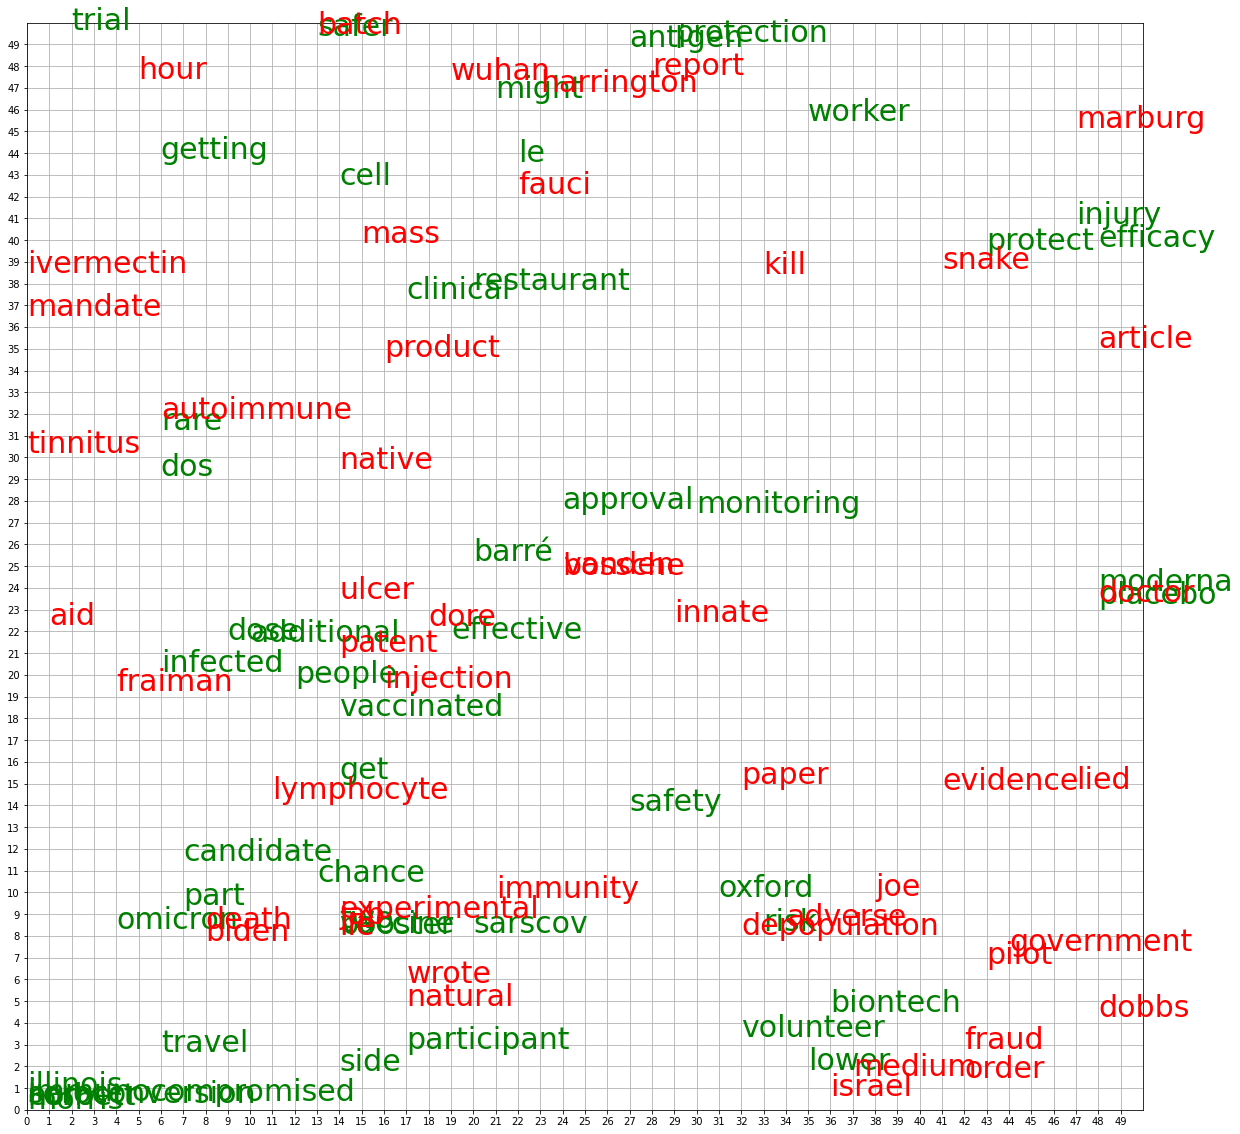

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.9679032839465153


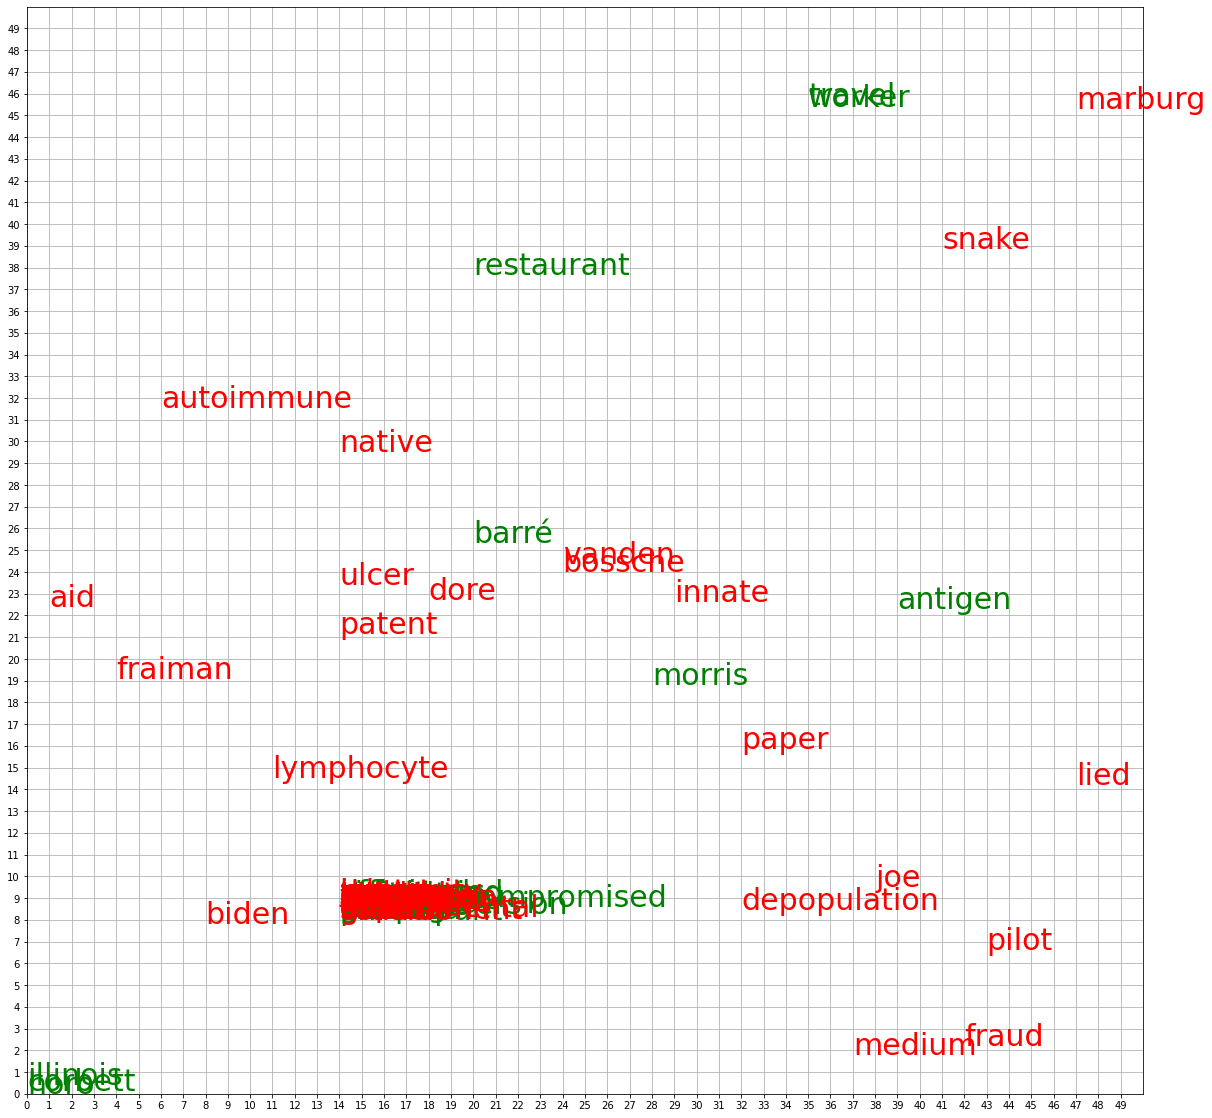

In [10]:
key_words = [s for _,s in key_pro_words + key_anti_words]
close_words = find_close_words(words_pa,key_words)
pro_words_pa = [words for i,words in enumerate(words_pa) if articles["label"][i]==1]
anti_words_pa = [words for i,words in enumerate(words_pa) if articles["label"][i]==0]
vector_colors = ['r' if i>len(key_pro_words) else 'g' for i,_ in enumerate(key_words)]

def sim(wiedza,do_czytania,learning_rate):
    # wiedza na start
    read_data = random_percent(wiedza,0.8)
    vectors = generate_vectors(prepare_dictionary(read_data,key_words,r=2),close_words)
    vectors = TfidfTransformer().fit_transform(list(vectors.values())).toarray()

    N = int(5*np.sqrt(len(vectors)))
    som = MiniSom(N, N, len(close_words), sigma=1, learning_rate=learning_rate, activation_distance='cosine')
    som.train_random(vectors,100,verbose=True)

    plot_vectors(som,vectors,vector_colors,key_words,N)

    read_data.extend(random_percent(do_czytania,0.5))
    vectors = generate_vectors(prepare_dictionary(read_data,key_words,r=2),close_words)
    vectors = TfidfTransformer().fit_transform(list(vectors.values())).toarray()

    som.train_random(vectors,100,verbose=True)

    plot_vectors(som,vectors,vector_colors,key_words,N)

sim(anti_words_pa,pro_words_pa,0.05)